# 优化和深度学习

在本节中，我们将讨论优化与深度学习之间的关系以及在深度学习中使用优化的挑战。对于深度学习问题，我们通常会先定义损失函数。一旦我们有了损失函数，我们就可以使用优化算法来尝试最小化损失。在优化中，损失函数通常被称为优化问题的目标函数。按照传统和惯则，大多数优化算法都关注的是最小化。如果我们需要最大化目标，那么有一个简单的解决方案：在目标函数前加负号即可。

## 优化的目标

尽管优化提供了一种最大限度地减少深度学习损失函数的方法，但实质上，优化和深度学习的目标是根本不同的。前者主要关注的是最小化目标，后者则关注在给定有限数据量的情况下寻找合适的模型。在 4.4节 中，我们详细讨论了这两个目标之间的区别。例如，训练错误和泛化错误通常不同：由于优化算法的目标函数通常是基于训练数据集的损失函数，因此优化的目标是减少训练错误。但是，深度学习（或更广义地说，统计推断）的目标是减少泛化错误。为了实现后者，除了使用优化算法来减少训练错误之外，我们还需要注意过拟合。

In [15]:
%matplotlib inline
import numpy as np
import paddle
from mpl_toolkits import mplot3d

为了说明上述不同的目标，让我们考虑经验风险和风险。如 subsec_empirical-risk-and-risk 所述，经验风险是训练数据集的平均损失，而风险则是整个数据群的预期损失。下面我们定义了两个函数：风险函数 f 和经验风险函数 g。假设我们只有有限量的训练数据。因此，这里的 g 不如 f 平滑。

In [7]:
def f(x):
    return x * np.cos(np.pi * x)

def g(x):
    return f(x) + 0.2 * np.cos(5 * np.pi * x)

下图说明，训练数据集的最低经验风险可能与最低风险（泛化错误）不同。

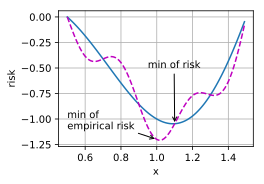

In [8]:
def annotate(text, xy, xytext):  #@save
    from matplotlib import pyplot as plt
    plt.gca().annotate(text, xy=xy, xytext=xytext,
                       arrowprops=dict(arrowstyle='->'))

x = np.arange(0.5, 1.5, 0.01, dtype='float32')
set_figsize((4.5, 2.5))
plot(x, [f(x), g(x)], 'x', 'risk')
annotate('min of\nempirical risk', (1.0, -1.2), (0.5, -1.1))
annotate('min of risk', (1.1, -1.05), (0.95, -0.5))

## 深度学习中的优化挑战

在本章中，我们将特别关注优化算法在最小化目标函数方面的性能，而不是模型的泛化错误。在 3.1节 中，我们区分了优化问题中的解析解和数值解。在深度学习中，大多数目标函数都很复杂，没有解析解。相反，我们必须使用数值优化算法。本章中的优化算法都属于此类别。

深度学习优化存在许多挑战。其中一些最令人烦恼的是局部最小值、鞍点和梯度消失。让我们来看看它们。

### 1. 局部最小值

对于任何目标函数$f(x)$，如果在$x$处对应的$f(x)$ 值小于在$x$附近任何其他点的$f(x)$值，那么$f(x)$ 可能是局部最小值。如果$f(x)$在$x$处的值是整个域上目标函数的最小值，那么$f(x)$是全局最小值。

例如，给定函数

$$f(x) = x \cdot \text{cos}(\pi x) \text{ for } -1.0 \leq x \leq 2.0,$$

我们可以近似该函数的局部最小值和全局最小值。

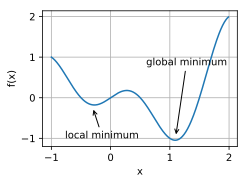

In [10]:
x = np.arange(-1.0, 2.0, 0.01, dtype='float32')
plot(x, [f(x), ], 'x', 'f(x)')
annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
annotate('global minimum', (1.1, -0.95), (0.6, 0.8))

深度学习模型的目标函数通常有许多局部最优解。当优化问题的数值解接近局部最优值时，随着目标函数解的梯度接近或变为零，通过最终迭代获得的数值解可能仅使目标函数局部最优，而不是全局最优。只有一定程度的噪音可能会使参数超出局部最小值。事实上，这是小批量随机梯度下降的有利特性之一，在这种情况下，小批量上梯度的自然变化能够将参数从局部极小值中移出。

### 2. 鞍点

除了局部最小值之外，鞍点也是梯度消失的另一个原因。鞍点是指函数的所有梯度都消失但既不是全局最小值也不是局部最小值的任何位置。考虑这个函数$f(x) = x^3$。它的一阶和二阶导数在$x=0$时消失。这时优化可能会停止，尽管它不是最小值。

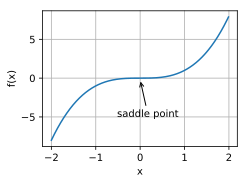

In [12]:
x = np.arange(-2.0, 2.0, 0.01, dtype='float32')
plot(x, [x**3], 'x', 'f(x)')
annotate('saddle point', (0, -0.2), (-0.52, -5.0))

如下例所示，较高维度的鞍点甚至更加隐蔽。考虑这个函数$f(x, y) = x^2 - y^2$。它的鞍点为 $(0, 0)$。这是关于$y$的最大值，也是关于$x$的最小值。此外，它看起来像马鞍，这就是这个数学属性的名字由来。

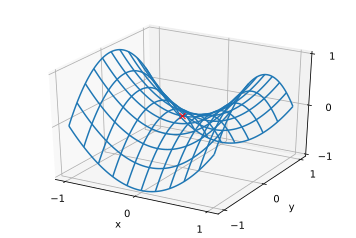

In [16]:
x, y = np.meshgrid(
    np.linspace(-1.0, 1.0, 101), np.linspace(-1.0, 1.0, 101))
z = x**2 - y**2

ax = plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_zticks(ticks)
plt.xlabel('x')
plt.ylabel('y');

我们假设函数的输入是 $k$ 维向量，其输出是标量，因此其Hessian矩阵（也称黑塞矩阵）将有 $k$ 特征值（参考 online appendix on eigendecompositions）。函数的解决方案可以是局部最小值、局部最大值或函数梯度为零的位置处的鞍点：

- 当函数在零梯度位置处的Hessian矩阵的特征值全部为正值时，我们有该函数的局部最小值。
- 当函数在零梯度位置处的Hessian矩阵的特征值全部为负值时，我们有该函数的局部最大值。
- 当函数在零梯度位置处的Hessian矩阵的特征值为负值和正值时，我们对函数有一个鞍点。

对于高维度问题，至少部分特征值为负的可能性相当高。这使得鞍点比局部最小值更有可能。我们将在下一节介绍凸性时讨论这种情况的一些例外情况。简而言之，凸函数是Hessian函数的特征值永远不是负值的函数。不幸的是，大多数深度学习问题并不属于这个类别。尽管如此，它还是研究优化算法的一个很好的工具。

### 3. 梯度消失

可能遇到的最隐蔽的问题是梯度消失。回想一下我们在 :numref:subsec_activation-functions 中常用的激活函数及其衍生函数。例如，假设我们想最小化函数$f(x) = \tanh(x)$，然后我们恰好从 $x = 4$ 开始。正如我们所看到的那样，$f$ 的梯度接近零。更具体地说，$f'(x) = 1 - \tanh^2(x)$，因此是 $f'(4) = 0.0013$。因此，在我们取得进展之前，优化将会停滞很长一段时间。事实证明，这是在引入 ReLU 激活函数之前训练深度学习模型相当棘手的原因之一。

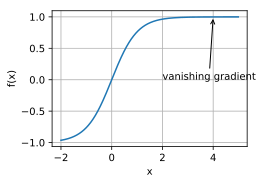

In [21]:
x = np.arange(-2.0, 5.0, 0.01, dtype='float32')
plot(x, [np.tanh(x)], 'x', 'f(x)')
annotate('vanishing gradient', (4, 1), (2, 0.0))

正如我们所看到的那样，深度学习的优化充满挑战。幸运的是，有一系列强大的算法表现良好，即使对于初学者也很容易使用。此外，没有必要找到最佳解决方案。局部最优解或其近似解仍然非常有用。

## 小结

- 最小化训练误差并不能保证我们找到最佳的参数集来最小化泛化误差。

- 优化问题可能有许多局部最小值。

- 问题可能有更多的鞍点，因为通常问题不是凸的。

- 梯度消失可能会导致优化停滞。重新参数化问题通常会有所帮助。对参数进行良好的初始化也可能是有益的。

## 练习

1. 考虑一个简单的的 MLP，它有一个隐藏层，比如，隐藏层中维度为$d$和一个输出。证明对于任何局部最小值，至少有$d！$个等效方案。
2. 假设我们有一个对称随机矩阵 $\mathbf{M}$，其中条目$M_{ij} = M_{ji}$各自从某种概率分布 $p_{ij}$中抽取。此外，假设 $p_{ij}(x) = p_{ij}(-x)$，即分布是对称的（详情请参见 :cite:Wigner.1958）。
	
    i. 证明特征值的分布也是对称的。也就是说，对于任何特征向量 $\mathbf{v}$，关联的特征值 $\lambda$ 满足 $P(\lambda > 0) = P(\lambda < 0)$ 的概率为 $P(\lambda > 0) = P(\lambda < 0)$。
    
    ii. 为什么以上没有 暗示 $P(\lambda > 0) = 0.5$？
3. 你能想到深度学习优化还涉及哪些其他挑战？
假设你想在（真实的）鞍上平衡一个（真实的）球。

	i. 为什么这很难？
   
   ii. 你也能利用这种效应来优化算法吗？